#  VRP Flow-Based Formulation

#### Keywords: VRP, Flow-Based, IP, Gurobi, Python, Networkx

$ \text{Variables} $

$x_{ij} =
\begin{cases}
1 & \text{if the vehicle travels from node } i \text{ to node } j \\
0 & \text{otherwise}
\end{cases}
$

$f_{ij}$ is the amount of flow (demand) carried on arc $(i,j)$

$K$ is the number of vehicles, $Q$ is vehicle capacity, and $d_i$ is demand at node $i$

\begin{equation*}
\begin{aligned}
& \underset{}{\text{Minimize}} 
& & \sum_{i=0}^{n} \sum_{\substack{j=0 \\ j \ne i}}^{n} c_{ij} \cdot x_{ij} \\
& \text{Subject to} \\
& & \sum_{\substack{j=0 \\ j \ne i}}^{n} x_{ij} = 1, \quad i = 1,\ldots,n, \\
& & \sum_{\substack{i=0 \\ i \ne j}}^{n} x_{ij} = 1, \quad j = 1,\ldots,n, \\
& & \sum_{j=1}^{n} x_{0j} = K, \quad \sum_{i=1}^{n} x_{i0} = K, \\
& & \sum_{j=0}^{n} f_{ij} - \sum_{j=0}^{n} f_{ji} = d_i, \quad i = 1,\ldots,n, \\
& & f_{ij} \le Q \cdot x_{ij}, \quad \forall i,j = 0,\ldots,n, \\
& & x_{ij} \in \{0,1\}, \quad \forall i \ne j,\ i,j = 0,\ldots,n, \\
& & f_{ij} \in \mathbb{R}_+, \quad \forall i,j = 0,\ldots,n.
\end{aligned}
\end{equation*}



##  Import Library and Model Enviroment

In [1]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
m = gp.Model("VRP_Flow")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13


### Create Data and Matrix of Distances

In [2]:
n = 24  # number of customers
K = 4  # number of vehicles
Q = 15 # Capacity of vehicle
d = [0] + list(np.random.randint(1, Q // 4 + 1, size=n))  # demands (0 for depot)

#Create a Random Matrix
c = np.random.randint(1, 100, size=(n+1, n+1))
# A_i,i = 0
np.fill_diagonal(c, 0)

### Variables

In [3]:
x = m.addVars(n+1, n+1, vtype=GRB.BINARY, name="x")
f = m.addVars(n+1, n+1, vtype=GRB.CONTINUOUS, lb=0, name="f")

## Mathematical Model of VRP (MTZ Formulation)

### Objective Function

In [4]:
m.setObjective(
    gp.quicksum(c[i][j] * x[i,j] for i in range(n+1) for j in range(n+1) if i != j),
    GRB.MINIMIZE
)

### Subject to:

In [5]:
# 1) Each customer visited exactly once
for i in range(1, n+1):
    m.addConstr(gp.quicksum(x[i,j] for j in range(n+1) if j != i) == 1)
    m.addConstr(gp.quicksum(x[j,i] for j in range(n+1) if j != i) == 1)

In [6]:
# 2) Depot constraints
m.addConstr(gp.quicksum(x[0,j] for j in range(1, n+1)) == K)
m.addConstr(gp.quicksum(x[i,0] for i in range(1, n+1)) == K)

<gurobi.Constr *Awaiting Model Update*>

In [7]:
# 3) Flow conservation
for i in range(1, n+1):
    m.addConstr(
        gp.quicksum(f[i,j] for j in range(n+1)) 
        - gp.quicksum(f[j,i] for j in range(n+1)) 
        == d[i])

In [8]:
# 4) Flow capacity on edges
for i in range(n+1):
    for j in range(n+1):
        if i != j:
            m.addConstr(f[i,j] <= Q * x[i,j])

### Solve the VRP (Flow-Based Formulation)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 674 rows, 1250 columns and 3552 nonzeros
Model fingerprint: 0x8f83061a
Variable types: 625 continuous, 625 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 0 rows and 50 columns
Presolve time: 0.01s
Presolved: 674 rows, 1200 columns, 3552 nonzeros
Variable types: 600 continuous, 600 integer (600 binary)
Found heuristic solution: objective 2099.0000000

Root relaxation: objective 1.881000e+02, 785 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It

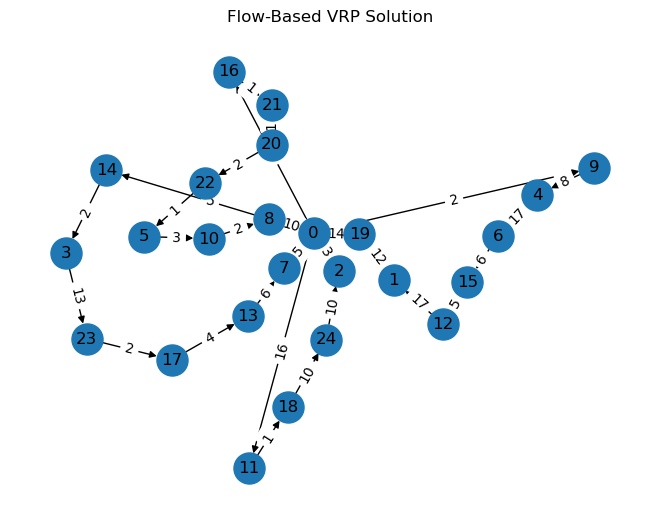

Optimal cost: 194.0
Route from 0 to 9
Route from 0 to 11
Route from 0 to 14
Route from 0 to 16
Route from 1 to 19
Route from 2 to 0
Route from 3 to 23
Route from 4 to 6
Route from 5 to 10
Route from 6 to 15
Route from 7 to 0
Route from 8 to 0
Route from 9 to 4
Route from 10 to 8
Route from 11 to 18
Route from 12 to 1
Route from 13 to 7
Route from 14 to 3
Route from 15 to 12
Route from 16 to 21
Route from 17 to 13
Route from 18 to 24
Route from 19 to 0
Route from 20 to 22
Route from 21 to 20
Route from 22 to 5
Route from 23 to 17
Route from 24 to 2


In [9]:
m.optimize()

# -------------
# NetworkX Plot
# -------------
if m.status == GRB.OPTIMAL:
    sol_x = m.getAttr('x', x)
    
    G = nx.DiGraph()
    for i in range(n+1):
        G.add_node(i)
    for i in range(n+1):
        for j in range(n+1):
            if i != j and sol_x[i,j] > 0.5:
                G.add_edge(i, j)

    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=500)
    edge_labels = {(i, j): c[i][j] for (i, j) in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Flow-Based VRP Solution")
    plt.show()

    print("Optimal cost:", m.objVal)
    for i in range(n+1):
        for j in range(n+1):
            if i != j and sol_x[i,j] > 0.5:
                print(f"Route from {i} to {j}")

### Literature

Toth, P. and Vigo, D. (2014). Vehicle Routing: Problems, Methods, and Applications, 2nd ed. SIAM. A comprehensive book on VRP formulations, algorithms, and variants.